In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns

In [13]:
train_dataset = pd.read_csv('./data/sign_mnist_train/sign_mnist_train.csv')
test_dataset = pd.read_csv('./data/sign_mnist_test/sign_mnist_test.csv')
print(train_dataset.shape)

(27455, 785)


In [4]:
#shuffling the dataset

train_dataset = train_dataset.sample(frac = 1.0).reset_index(drop = True)
test_dataset = test_dataset.sample(frac = 1.0).reset_index(drop = True)

In [5]:
# Peeking the dataset
train_dataset.iloc[:4,:10]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9
0,7,94,97,103,107,111,115,117,120,121
1,22,108,115,122,125,128,133,137,141,144
2,13,139,141,143,144,146,147,150,149,151
3,11,135,136,136,136,137,137,137,137,137


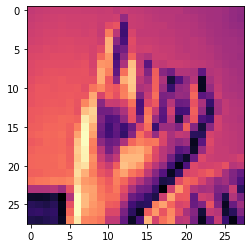

In [9]:
def make_image(arr , label=True):
    arr = np.array(arr)
    start_idx = 1 if label else 0
    return arr[start_idx:].reshape(28,28).astype(float)

image = make_image(train_dataset.iloc[0])
plt.imshow(image, cmap = 'magma')
plt.show()

In [6]:
train_data_og = train_dataset.copy()

v_index = int(train_dataset.shape[0]*0.1)

validation_data = train_data_og.iloc[:v_index]
train_data = train_data_og.iloc[v_index:]

#validation_data.shape

Y_train = train_data['label']
Y_test = test_dataset['label']
Y_validation = validation_data['label']

X_train = train_data.drop('label',axis = 1).values.reshape(train_data.shape[0], 28, 28, 1)
X_test = test_dataset.drop('label',axis = 1).values.reshape(test_dataset.shape[0], 28, 28, 1)
X_validation = validation_data.drop('label',axis = 1).values.reshape(validation_data.shape[0], 28, 28, 1)

In [7]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")

X_train_flow = generator.flow(X_train, Y_train, batch_size=32)
X_val_flow = generator.flow(X_validation, Y_validation, batch_size=32)

In [11]:
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    
                    Flatten(),
                    
                    Dense(units=1024, activation="relu"),                 
                    Dense(units=256, activation="relu"),
                    Dropout(0.5),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 512)         590336    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, 
                    validation_data=X_val_flow, 
                    epochs=100,
                    callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=5,
                            restore_best_weights=True), 
                        
                            learning_rate_reduction
                    ])

Epoch 1/100
773/773 [==============================] - 38s 47ms/step - loss: 1.7364 - accuracy: 0.4423 - val_loss: 0.4588 - val_accuracy: 0.8474
Epoch 2/100
773/773 [==============================] - 37s 48ms/step - loss: 0.3399 - accuracy: 0.8842 - val_loss: 0.1307 - val_accuracy: 0.9585
Epoch 3/100
773/773 [==============================] - 36s 47ms/step - loss: 0.1368 - accuracy: 0.9556 - val_loss: 0.0704 - val_accuracy: 0.9796
Epoch 4/100
773/773 [==============================] - 35s 45ms/step - loss: 0.0838 - accuracy: 0.9739 - val_loss: 0.0595 - val_accuracy: 0.9800
Epoch 5/100
773/773 [==============================] - 35s 45ms/step - loss: 0.0653 - accuracy: 0.9805 - val_loss: 0.0397 - val_accuracy: 0.9865
Epoch 6/100
773/773 [==============================] - 34s 44ms/step - loss: 0.0448 - accuracy: 0.9864 - val_loss: 0.0338 - val_accuracy: 0.9894
Epoch 7/100
773/773 [==============================] - 34s 44ms/step - loss: 0.0458 - accuracy: 0.9869 - val_loss: 0.0214 - val_ac

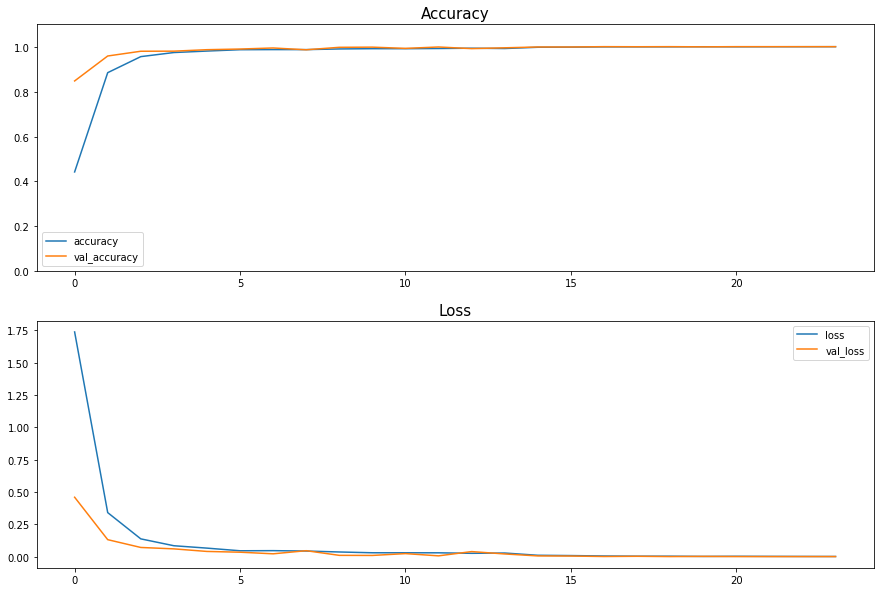

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [52]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

accuracy_score(Y_test,pred)


0.9894032348020078

In [46]:
import cv2

img_array = cv2.imread('./test.jpg', cv2.IMREAD_GRAYSCALE)
img_array = img_array.flatten()
img_array = img_array.reshape(28, 28, 1)
img_array = np.expand_dims(img_array,0)
img_array.shape

(1, 28, 28, 1)

In [53]:
pred2 = model.predict(img_array)
display(pred2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)